In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchtext.data import Field, TabularDataset, BucketIterator
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
import numpy as np
import json
import random
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from gensim.parsing.porter import PorterStemmer

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/{'.//'}

%cd LoyalAI
%ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive
/gdrive/My Drive/LoyalAI
data_full.json  metrics.pt  test.csv   valid.csv
LoyalAI.ipynb   model.pt    train.csv


In [ ]:
with open('data_full.json', 'r') as file:
    all_data = json.load(file)
#     print(len(dic))
    
oos_train_df = pd.DataFrame(all_data["oos_train"])
oos_val_df = pd.DataFrame(all_data["oos_val"])
oos_test_df = pd.DataFrame(all_data["oos_test"])

ins_train_df = pd.DataFrame(all_data["train"])
ins_val_df = pd.DataFrame(all_data["val"])
ins_test_df = pd.DataFrame(all_data["test"])
# ins_train_df.describe()

In [ ]:
seed = 2
random.seed(a=seed)
arr = random.sample([i for i in range(150)], k=20)
names = pd.unique(ins_train_df[1])
picked = [names[i] for i in arr]
# print(names)
in_train = ins_train_df.loc[ins_train_df[1].isin(picked)]
in_train.describe()

in_test = ins_test_df.loc[ins_test_df[1].isin(picked)]
in_val = ins_val_df.loc[ins_val_df[1].isin(picked)]

In [ ]:
train = pd.concat([in_train, oos_train_df])
test = pd.concat([in_test, oos_test_df])
val = pd.concat([in_val, oos_val_df])

In [ ]:
from gensim.utils import simple_preprocess
train['token'] = [simple_preprocess(line, deacc=True) for line in train[0]] 
test['token'] = [simple_preprocess(line, deacc=True) for line in test[0]] 
val['token'] = [simple_preprocess(line, deacc=True) for line in val[0]] 

In [ ]:
in_train.head(10)
input_features, y_train = train['token'], train[1]
X_val, y_val = val['token'], val[1]
X_test, y_test = test['token'], test[1]


In [ ]:
porter_stemmer = PorterStemmer()
new_input2 = pd.DataFrame(input_features).reset_index(drop=True)
new_input2['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in text] for text in new_input2['token']]
# blah

new_test2 = pd.DataFrame(X_test).reset_index(drop=True)
new_test2['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in text] for text in new_test2['token']]

new_val2 = pd.DataFrame(X_val).reset_index(drop=True)
new_val2['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in text] for text in new_val2['token']]

In [ ]:
train_features = [' '.join(first) for first in new_input2['stemmed_tokens']]
# input_features[0]

test_features = [' '.join(first) for first in new_test2['stemmed_tokens']]

val_features = [' '.join(first) for first in new_val2['stemmed_tokens']]

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X = pd.DataFrame(train_features)
# X = train_features
y = np.where(y_train!='oos', 0, 1)
X_under, y_under = undersample.fit_resample(X, y)
X_over, y_over = oversample.fit_resample(X, y) #[0], train[1])
# X_over = pd.DataFrame(X_over)
# y_train

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# X_over = pd.DataFrame(X_over)
# y_over.shape, X_under.shape, X.shape, new_something.shape
# X_over.head()

In [ ]:
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('text', text_field), ('label', label_field)]


In [ ]:
df_tr = pd.DataFrame(train_features, columns=['text']) #train_features
df_tr['label'] = y #np.where(y_over!='oos', 0, 1)

df_tt = pd.DataFrame(test_features, columns=['text'])
df_tt['label'] = np.where(y_test!='oos', 0, 1)

df_v = pd.DataFrame(val_features, columns=['text'])
df_v['label'] = np.where(y_val!='oos', 0, 1)

In [ ]:
df_tr.head()

,text,label
0,doe ireland have ani travel alert should be aw...,0
1,doe north korea have ani travel alert should b...,0
2,ar there ani travel alert for russia,0
3,doe spain have ani travel alert should be awar of,0
4,ar there ani travel alert for north korea,0


In [ ]:
df_tr.to_csv('./train.csv', index=False)
df_v.to_csv('./valid.csv', index=False)
df_tt.to_csv('./test.csv', index=False)

In [ ]:
device='cpu'
train, valid, test = TabularDataset.splits(path='./', train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

In [ ]:
# for a in train_iter:
#   print(a)

In [ ]:
# new_input2

In [ ]:
#@title
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [ ]:
#@title
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [ ]:
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = "./",
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for ((text, text_len), labels), _ in train_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for ((text, text_len), labels), _ in valid_loader:
                      labels = labels.to(device)
                      text = text.to(device)
                      text_len = text_len.to(device)
                      output = model(text, text_len)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=20)

Epoch [1/20], Step [33/1320], Train Loss: 0.3273, Valid Loss: 0.4001
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [1/20], Step [66/1320], Train Loss: 0.0735, Valid Loss: 0.2981
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [2/20], Step [99/1320], Train Loss: 0.0902, Valid Loss: 0.2427
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [2/20], Step [132/1320], Train Loss: 0.0355, Valid Loss: 0.2632
Epoch [3/20], Step [165/1320], Train Loss: 0.0483, Valid Loss: 0.2370
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [3/20], Step [198/1320], Train Loss: 0.0171, Valid Loss: 0.2283
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [4/20], Step [231/1320], Train Loss: 0.0300, Valid Loss: 0.2563
Epoch [4/20], Step [264/1320], Train Loss: 0.0055, Valid Loss: 0.2960
Epoch [5/20], Step [297/1320], Train Loss: 0.0137, Valid Loss: 0.3147
Epoch [5/20], Step [330/1320], Train Loss: 0.0084, Va

Model loaded from <== ./model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9736    0.7020    0.8158      1000
           0     0.6610    0.9683    0.7857       600

    accuracy                         0.8019      1600
   macro avg     0.8173    0.8352    0.8007      1600
weighted avg     0.8564    0.8019    0.8045      1600



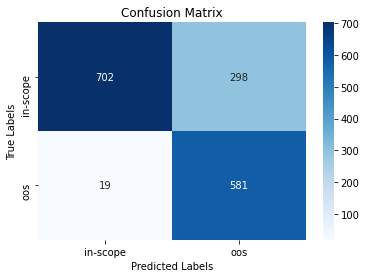

In [ ]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for ((text, text_len), labels), _ in test_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['in-scope', 'oos'])
    ax.yaxis.set_ticklabels(['in-scope', 'oos'])
    
    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint('./model.pt', best_model, optimizer)
evaluate(best_model, test_iter)